<a href="https://colab.research.google.com/github/HimakarParadi/hello-world/blob/master/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

Mounted at /content/gdrive/


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
# from cache import cache

In [ ]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras.models import Model
# import coco
# import kera

In [ ]:
_, filenames_train, captions_train = coco.load_records(train=True)

NameError: ignored

In [ ]:
num_images_train = len(filenames_train)

NameError: ignored

In [ ]:
#define xception model from keras
image_model = Xception(include_top=True, weights='imagenet')
image_model.summary()

91884032/91884032 [==============================] - 5s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:

transfer_layer = image_model.get_layer('avg_pool')
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)
image_model_transfer.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 20,861,480
Trainable params: 20,806,952
Non-trainable params: 54,528
__________________________________________________________________________________________________


In [ ]:
#convert all the images into [2048,0 ] vectors using xception

def process_images(data_dir, filenames, batch_size=32):

    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

In [ ]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train_trail.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

In [ ]:
def load_image(path, size=None):

    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [ ]:
def show_image(idx, train):

    if train:
        # Use an image from the training-set.
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)

    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

In [ ]:
transfer_values_train_trail = process_images_train()

NameError: ignored

In [ ]:
#import transfer values uptained from CNN models
import pickle
with open("/content/gdrive/MyDrive/Colab Notebooks/transfer_values_train_trail.pkl",'rb') as f:

    transfer_values_train=pickle.load(f)

with open("/content/gdrive/MyDrive/Colab Notebooks/captions_train.pkl",'rb') as f:

    captions_train=pickle.load(f)

In [ ]:

print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

dtype: float16
shape: (118287, 2048)


In [ ]:

#initiate starting and ending marks form the
mark_start = 'ssss '
mark_end = ' eeee'

In [ ]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]

    return captions_marked

In [ ]:

captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

In [ ]:
captions_train[0]

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

In [ ]:
#flatten the captions into one single vector
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]

    return captions_list

In [ ]:
captions_train_flat = flatten(captions_train_marked)

In [ ]:
num_words = 10000

In [ ]:
class TokenizerWrap(Tokenizer):

    def __init__(self, texts, num_words=None):

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):

        word = " " if token == 0 else self.index_to_word[token]
        return word

    def tokens_to_string(self, tokens):

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]

        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text

    def captions_to_tokens(self, captions_listlist):

        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]

        return tokens

In [ ]:
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

In [ ]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

In [ ]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

In [ ]:
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

In [ ]:
tokens_train[0]

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
 [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
 [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
 [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
 [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

In [ ]:
def get_random_caption_tokens(idx):

    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

In [ ]:


# generate batch to train the model batch wise
def batch_generator(batch_size):

    while True:
        idx = np.random.randint(num_images_train,
                                size=batch_size)

        transfer_values = transfer_values_train[idx]

        tokens = get_random_caption_tokens(idx)

        num_tokens = [len(t) for t in tokens]

        max_tokens = np.max(num_tokens)

        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')

        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        y_data = \
        {
            'decoder_output': decoder_output_data
        }

        yield (x_data, y_data)

In [ ]:
#initiate batch size
batch_size = 512

In [ ]:

generator = batch_generator(batch_size=batch_size)

In [ ]:
#number of training images
num_images_train=118287

In [ ]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [ ]:
#sample batch input for transfer values
batch_x['transfer_values_input'][0]

array([0.00936, 0.1218 , 0.07184, ..., 0.2632 , 0.01482, 0.02982],
      dtype=float16)

In [ ]:
#sample batch input for decoder
batch_x['decoder_input'][0]

array([  2,   1,  49,  95, 474,   1,  37,  75,   8,   1,  37, 354,   3,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

In [ ]:
#sample batch output from decoder
batch_y['decoder_output'][0]

array([  1,  49,  95, 474,   1,  37,  75,   8,   1,  37, 354,   3,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

In [ ]:
#number of training captions
num_captions_train=[len(captions) for captions in captions_train]

In [ ]:
total_num_captions_train=np.sum(num_captions_train)

In [ ]:
#steps for epoch
steps_per_epoch=int(total_num_captions_train / batch_size)
steps_per_epoch

1155

In [ ]:
state_size=512

In [ ]:
embedding_size=128

In [ ]:
transfer_values_size=2048

In [ ]:
transfer_values_input=Input(shape=(transfer_values_size,),name='transfer_values_input')

In [ ]:
transfer_values_input

<tf.Tensor 'transfer_values_input:0' shape=(?, 2048) dtype=float32>

In [ ]:
decoder_transfer_map=Dense(state_size,activation='tanh',name='decoder_transfer_map')

In [ ]:
decoder_input=Input(shape=(None,),name='decoder_input')

In [ ]:
decoder_embedding=Embedding(input_dim=num_words,output_dim=embedding_size,name='decoder_embedding')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
decoder_gru1=GRU(state_size,name='decoder_gru1',return_sequences=True)

decoder_gru2=GRU(state_size,name='decoder_gru2',return_sequences=True)

decoder_gru3=GRU(state_size,name='decoder_gru3',return_sequences=True)

In [ ]:

decoder_dense=Dense(num_words,activation='linear',name='decoder_output')

In [ ]:
#connect all the decoder's

def connect_decoder(transfer_values):
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input

    # Connect the embedding-layer.
    net = decoder_embedding(net)

    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)

    return decoder_output

In [ ]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

#create decoder model with 3GRU's
decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])


In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
transfer_values_input (InputLay [(None, 2048)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 128)    1280000     decoder_input[0][0]              
__________________________________________________________________________________________________
decoder_transfer_map (Dense)    (None, 512)          1049088     transfer_values_input[0][0]      
____________________________________________________________________________________________

In [ ]:

def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.

    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
    # 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [ ]:
#optimizer to optimise the loss value
optimizer=RMSprop(lr=1e-3)


In [ ]:

#optimizer to optimise the loss value
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001, decay=1e-6)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:

decoder_target=tf.placeholder(dtype='int32',shape=(None,None))

In [ ]:


decoder_model.compile(optimizer='adam',
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

In [ ]:
#model checkpoint to save the model weights
path_checkpoint = '/content/gdrive/MyDrive/Colab Notebooks/22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [ ]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [ ]:
callbacks = [callback_checkpoint, callback_tensorboard]

In [ ]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
transfer_values_input

<tf.Tensor 'transfer_values_input:0' shape=(?, 2048) dtype=float32>

In [ ]:
#fir the model
decoder_model.fit_generator(generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=0,
                            callbacks=callbacks)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training_v1.py:1242: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


In [ ]:
from tensorflow.keras.applications import Xception
from keras.models import Model
Xception_model = Xception(include_top=True, weights='imagenet')
image_model_transfer = Model(Xception_model.input, Xception_model.get_layer("avg_pool").output) #I wanna cut all layers after 'fc2'

# image_model_transfer = vgg16_model.get_layer("fc2").output
image_size=(299,299)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
transfer_values_input (InputLay [(None, 2048)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 128)    1280000     decoder_input[0][0]              
__________________________________________________________________________________________________
decoder_transfer_map (Dense)    (None, 512)          1049088     transfer_values_input[0][0]      
____________________________________________________________________________________________

In [ ]:
!pip install gtts
from gtts import gTTS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 96 kB 7.3 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [ ]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    # image = load_image(image_path, size=image_size)

    image = image_path

    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)
#     print(image_batch.shape)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }


        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)
        if (sampled_word!= 'eeee'):
        # Append the word to the output-text.
            output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()

    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

    #use gtts to generate the audio file
    tts=gTTS(text=output_text,lang="en-us")
    tts.save('sample1.mp3')


In [ ]:
# # generate_caption("/content/gdrive/MyDrive/Colab Notebooks/dog.jpg")
# image = load_image("/content/gdrive/MyDrive/Colab Notebooks/dog.jpg", size=image_size)
# # image = load_image("images-2.jpeg", size=image_size)
# generate_caption(image)

<ipython-input-89-00006c2e2201>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


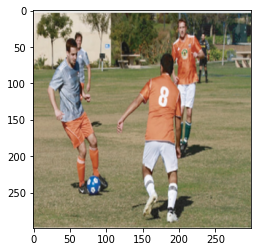

Predicted caption:
 a group of young men playing a game of soccer



In [ ]:
image = load_image("/content/gdrive/MyDrive/Colab Notebooks/sample1.jpg", size=image_size)
generate_caption(image)

<ipython-input-366-00006c2e2201>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


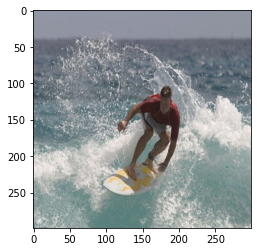

Predicted caption:
 a person riding a surf board on a wave



In [ ]:
image = load_image("sample2.jpg", size=image_size)
generate_caption(image)

<ipython-input-366-00006c2e2201>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


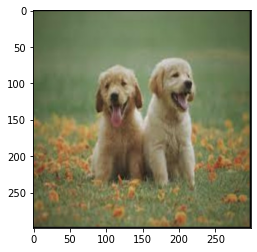

Predicted caption:
 a couple of dogs are standing in the grass



In [ ]:
image = load_image("sample3.jpg", size=image_size)
generate_caption(image)